# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from openpyxl import *
from scipy.optimize import curve_fit
from scipy.stats import gompertz
from sklearn.metrics import r2_score
from logistic import logistic as logistic
### Preamble

# add ODYM module directory to system path, relative
MainPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Global_model', 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Global_model', 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)

Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items)
Nr = len(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Nk = len(IndexTable.Classification[IndexTable.index.get_loc('Capacity')].Items)
Np = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Parts')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
Nv = len(IndexTable.Classification[IndexTable.index.get_loc('Make')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)

INFO (<ipython-input-1-8341fa8fa5fc> <<module>>): ### 1. - Initialize.
INFO (<ipython-input-1-8341fa8fa5fc> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 20. Check if all classifications are present. If yes, you are good to go!
INFO (<ipython-input-1-8341fa8fa5fc> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-1-8341fa8fa5fc> <<module>

### We import the stock data

In [2]:

### This data comes from SSB website for registered vehicels
stock = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/IUS_LDV_IEA_Xu_2019_2050/IUS_LDV_IEA_Xu.xlsx', sheet_name='LDV_stock')
stock['geo'] = 'Global'
stock.to_pickle('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/lightDutyVehicles_motoEnergy_segments_Global_2019_2050/lightDutyVehicles_IUS_global_2019_2050.pkl')

In [3]:
stock.head()

,year,value,unit,comment,geo
0,2019,503.000000,million,Assumed linear increase from 2019 to 2050,Global
1,2020,612.580645,million,Assumed linear increase from 2019 to 2050,Global
2,2021,722.161290,million,Assumed linear increase from 2019 to 2050,Global
3,2022,831.741935,million,Assumed linear increase from 2019 to 2050,Global
4,2023,941.322581,million,Assumed linear increase from 2019 to 2050,Global


In [4]:
stock_corr = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/IUS_LDV_IEA_Xu_2019_2050/IUS_LDV_IEA_Xu.xlsx', sheet_name='LDV_stock_corrected')
stock_corr['geo'] = 'Global'
stock_corr.to_pickle('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/lightDutyVehicles_motoEnergy_segments_Global_2019_2050/lightDutyVehicles_IUS_global_2019_2050_corrected.pkl')

In [5]:
stock_corr.set_index('year', inplace = True)
stock.set_index('year', inplace=True)
stock_corr.head()

,value,unit,comment,geo
year,,,,
2019,1100.000000,million,Assumed linear increase from 2019 to 2050,Global
2020,1190.322581,million,Assumed linear increase from 2019 to 2050,Global
2021,1280.645161,million,Assumed linear increase from 2019 to 2050,Global
2022,1370.967742,million,Assumed linear increase from 2019 to 2050,Global
2023,1461.290323,million,Assumed linear increase from 2019 to 2050,Global


### We import the population data

In [6]:
population = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/population_global_UN/population_global_1950_2050_UN.xlsx', sheet_name='Columns', skiprows=1)

In [7]:
population= population[['Location','World']]

In [8]:
population.dropna(inplace=True)

In [9]:
population = population.rename(columns={'Location': 'year'})

In [10]:
population.to_pickle('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/lightDutyVehicles_motoEnergy_segments_Global_2019_2050/population_Global_UN.pkl')

### Calculate vehicle ownership per capita

In [11]:
population.rename(columns={'World':'value'}, inplace=True)

In [12]:
population.head()

,year,value
1,1950,2536275.0
2,1951,2583817.0
3,1952,2630584.0
4,1953,2677230.0
5,1954,2724302.0


In [13]:
#stock.set_index('year', inplace=True)
#stock_corr.set_index('year', inplace=True)
#population.set_index('year', inplace=True)

In [27]:
vpc = stock['value']/(population['value']/1000)
vpc_corr = stock_corr['value']/(population['value']/1000)

In [31]:
vpc = pd.DataFrame(vpc)


In [32]:
vpc.dropna(inplace=True)

In [34]:
vpc_corr = pd.DataFrame(vpc_corr)


In [35]:
vpc_corr.dropna(inplace=True)

In [36]:
vpc_corr.head()

,value
year,
2019,0.142587
2020,0.152694
2021,0.162612
2022,0.172352
2023,0.181923


In [18]:
population.set_index('year', inplace=True)

### Visualize values

Text(0, 0.5, 'Vehicles per capita')

indfont: score(<Font '.New York' (NewYork.ttf) normal normal 400 normal>) = 10.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal regular normal>) = 10.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal bold normal>) = 10.335
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal bold normal>) = 10.335
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Noto S

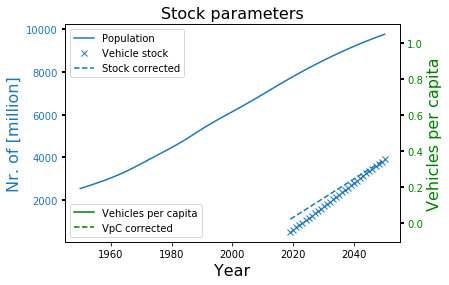

In [19]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(population.index.values, 
            population['value'].values/1000, color='tab:blue') 
ax1.plot(stock.index.values, 
            stock['value'].values, 'x', color='tab:blue') 
ax1.plot(stock_corr.index.values, 
            stock_corr['value'].values, '--') 
ax1.set_ylabel('Nr. of [million]',color='tab:blue',fontsize =16)
ax1.legend(['Population', 'Vehicle stock', 'Stock corrected'], loc='best',prop={'size':10})
ax1.set_title('Stock parameters', fontsize=16)
ax1.set_xlabel('Year',fontsize =16)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize='medium', width=2)
ax2.plot(vpc.index.values, 
            vpc['value'].values, 'g') 
ax2.plot(vpc_corr.index.values, 
            vpc_corr['value'].values, 'g--')
ax2.tick_params(axis='y', labelcolor='g', labelsize='medium', width=2)
ax2.legend(['Vehicles per capita', 'VpC corrected'], loc='lower left',prop={'size':10})
ax2.set_ylabel('Vehicles per capita', color='g', fontsize =16)

In [20]:
vpc['comment'] = 'Calculated using vehicle stock data from Xi et al. and popultion data from UN.'
vpc['script'] = '/Users/fernaag/Box/BATMAN/Coding/Global_model/data_handling/fitting_and_preparation/vehicle_stock_Global.ipynb'

In [21]:
vpc_corr['comment'] = 'Corrected data of Xi by looking at their citations'
vpc_corr['script'] = '/Users/fernaag/Box/BATMAN/Coding/Global_model/data_handling/fitting_and_preparation/vehicle_stock_Global.ipynb'

In [22]:
vpc.to_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/VpC_Global_2019_2050/VpC_Global_2019_2050_Xi.xlsx')
vpc_corr.to_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/VpC_Global_2019_2050/VpC_Global_2019_2050_corrected.xlsx')

### No we fit and create some scenarios for the VpC and population

Fit vehicles per capita

In [24]:
vpc.index.values

array([], dtype=int64)

In [38]:
# Trying polynomial fit
degree = 4
t = np.arange(1950,2051)
popt, pcov = curve_fit(logistic, vpc.index.values, vpc.value.values, bounds=([min(vpc.index.values), 0., 0.05, 0.], [max(vpc.index.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
vpc_fit = logistic(t, *popt)
popt1, pcov = curve_fit(logistic, vpc_corr.index.values, vpc_corr.value.values, bounds=([min(vpc_corr.index.values), 0., 0.05, 0.], [max(vpc_corr.index.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
vpc_fit_corr = logistic(t, *popt1)


Text(0.5, 0, 'Year')

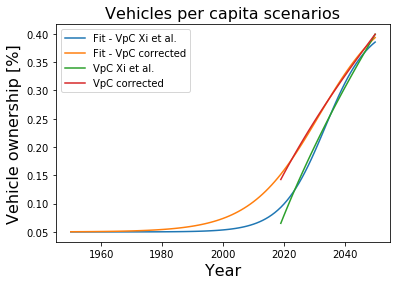

In [39]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(t, 
        vpc_fit) 
ax.plot(t, 
        vpc_fit_corr) 
ax.plot(vpc.index.values, 
        vpc['value'].values) 
ax.plot(vpc.index.values, 
        vpc_corr['value'].values) 
ax.legend(['Fit - VpC Xi et al.', 'Fit - VpC corrected', 'VpC Xi et al.', 'VpC corrected'], loc='best',prop={'size':10})
ax.set_ylabel('Vehicle ownership [%]',fontsize =16)
ax.set_title('Vehicles per capita scenarios', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

### With these scenarios we can calculate the total stock of vehicles. We use the logistic fits for the population and the polynomial fit for the ownership

In [40]:
StockArray = np.zeros((Nz, Nr, Nt))

In [41]:
StockArray[0,:,:]= np.einsum('t,t->t', population.value.values, vpc_fit_corr) # Each scenario is multiplied corrispondingly for each variable
StockArray[1,:,:]= np.einsum('t,t->t', population.value.values, vpc_fit) # Each scenario is multiplied corrispondingly for each variable

In [42]:
np.save('/Users/fernaag/Box/BATMAN/Data/Database/data/03_scenario_data/global_model/stock_population_vpc/IUS_World_1950_2050_Xi', StockArray, allow_pickle=True)

# Now we use OICA data instead

In [43]:
fleet = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/IUS_passengerCars_OICA_2005_2015/PC_Vehicles-in-use.xlsx', skiprows=5)

In [44]:
world = fleet[fleet['REGIONS/COUNTRIES']== 'ALL COUNTRIES'].reset_index(drop=True)

In [45]:
world

,REGIONS/COUNTRIES,Unnamed: 1,Unnamed: 2,Unnamed: 3,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Unnamed: 15,Variation 2015/2014
0,ALL COUNTRIES,NaN,NaN,NaN,653854,679153.837395,701690.28603,727404.947327,747899.110978,775572.823905,808401.00871,834915.648607,869082.972518,907061.78083,947079.618,NaN,0.044118


In [46]:
world = world.melt()

In [47]:
world.dropna(inplace=True)

In [48]:
world.drop(index=[0, 16], inplace=True)

In [49]:
max(world.variable.values.astype(int))

2015

In [50]:
world.tail()

,variable,value
10,2011,808401
11,2012,834916
12,2013,869083
13,2014,907062
14,2015,947080


In [51]:
# Trying logistic
t = np.arange(1950,2051)
popt, pcov = curve_fit(logistic, world.variable.values, world.value.values, bounds=([min(world.variable.values.astype(int)), 0., 10000, 50000], [max(world.variable.values.astype(int)), 100, 300000, 4000000])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
world_fit = logistic(t, *popt)

In [52]:
vpc_new = world_fit/population.value.values

Text(0, 0.5, 'Vehicles per capita')

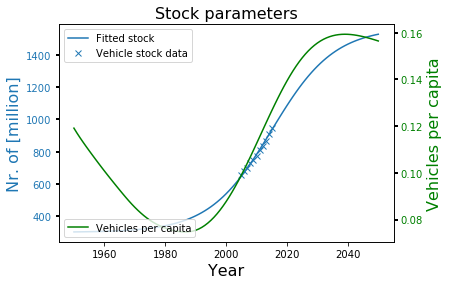

In [53]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t, 
            world_fit/1000, color='tab:blue') 
ax1.plot(world.variable.values, 
            world.value.values/1000, 'x', color='tab:blue') 
ax1.set_ylabel('Nr. of [million]',color='tab:blue',fontsize =16)
ax1.legend(['Fitted stock', 'Vehicle stock data', 'Stock corrected'], loc='best',prop={'size':10})
ax1.set_title('Stock parameters', fontsize=16)
ax1.set_xlabel('Year',fontsize =16)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize='medium', width=2)
ax2.plot(t, 
            vpc_new, 'g') 
ax2.tick_params(axis='y', labelcolor='g', labelsize='medium', width=2)
ax2.legend(['Vehicles per capita', 'VpC corrected'], loc='lower left',prop={'size':10})
ax2.set_ylabel('Vehicles per capita', color='g', fontsize =16)

Text(0.5, 0, 'Year')

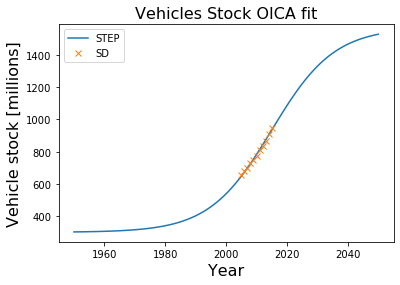

In [54]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(t, 
            world_fit/1000) 
ax.plot(world.variable.values, world.value.values/1000, 'x')
ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items, loc='best',prop={'size':10})
ax.set_ylabel('Vehicle stock [millions]',fontsize =16)
ax.set_title('Vehicles Stock OICA fit', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

Text(0.5, 0, 'Year')

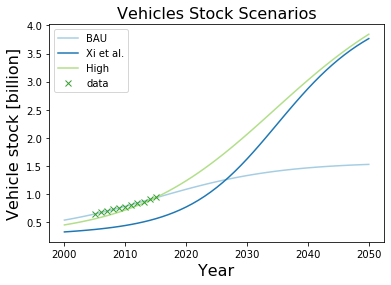

In [56]:
from cycler import cycler
import seaborn as sns
custom_cycler = cycler(color=sns.color_palette('Paired', 11)) #'Set2', 'Paired', 'YlGnBu'
fig, ax = plt.subplots()
ax.set_prop_cycle(custom_cycler)
ax.plot(t[50:], 
            world_fit[50:]/1000000) 
ax.plot(t[50:], 
            np.einsum('t,t->t', population.value.values[50:], vpc_fit[50:])/1000000) 
ax.plot(t[50:], 
            np.einsum('t,t->t', population.value.values[50:], vpc_fit_corr[50:])/1000000) 
ax.plot(world.variable.values, world.value.values/1000000, 'x')
ax.legend(['BAU', 'Xi et al.', 'High', 'data'], loc='best',prop={'size':10})
ax.set_ylabel('Vehicle stock [billion]',fontsize =16)
ax.set_title('Vehicles Stock Scenarios', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

In [41]:
StockArray = np.zeros((Nz, Nr, Nt))
StockArray[0,:,:]= np.einsum('t,t->t', population.value.values, vpc_fit_corr) # High
StockArray[1,:,:]= np.einsum('t,t->t', population.value.values, vpc_fit) # Medium
StockArray[2,:,:] = world_fit # Low
np.save('/Users/fernaag/Box/BATMAN/Data/Database/data/03_scenario_data/global_model/IUS/passengerCars_World_1950_2050_OICA', StockArray)